In [384]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

# Load basic science tools
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from numpy.random import rand, randint, uniform, choice, normal, randn 

## Classical MD

!["Cu atoms"](https://upload.wikimedia.org/wikipedia/commons/4/42/Cudeposition.gif)

!["Water molecules"](https://upload.wikimedia.org/wikipedia/commons/f/f4/MD_water.gif)

### Is MD is just Newton laws applied on big systems?

**Not quite: Noble prize in Chemistry 2013 just for MD**

Classical molecular dynamics (MD) is a common computational chemistry technique for studying complex systems, such as proteins, polymers, and energy materials. More and more molecular dynamics simulation is being used to aid in the analysis of experimental data from NMR, IR, UV spectroscopies as well as elastic-scattering techniques, such as small angle scattering or diffraction.

- [2013 Noble Lectures by M Karplus, A Warshell, M Levitt](https://www.youtube.com/watch?v=NuaeD9xYBtY)

![](./figs/1466565515216.jpg)

For example, the figure below is from the work of Knight and Hub (Nucl Acid Res 2018), showing the agreement between experimental data and that determined from simulation for a series of biomolecules. However, few users of these scattering technique have formal training in classical simulation, which often leads to their use without a full understanding of some of the complexities and subtleties. Therefore this open learning module aims ot provide an accessible route for users of scattering techniques to understand the methodology of molecular dynamics simulation, some of the pitfalls, and understand how scattering data may be obtained from simulation. We hope that this will increase the number of those confident to use classical simulation to understand their experimental data, while improving the quality of analysis.

### Timescales and Lengthscales

![](./figs/md-timescales.png)

## Energy function (force fields) used in classical MD

### Non-bonded interactions: Van der Waals

In [1]:
def E_lj(r, sig=1, eps=1):
    
    """Lennard-Jones potential for Van der Waals interaction energy.
    
    Parameters
    ----------
    r: Distance between two particles (Å)
    epsilon: Negative of the potential energy at equilibrium bond length (eV)
    sigma:   Distance at which the potential energy is zero (Å)
    """
    
    return 4 * eps *  ( (sig/r)**12 -(sig/r)**6 )

In [4]:
@widgets.interact(sig=(1,5),eps=(0.1,5))
def plot_lj(sig=1, eps=1):
    
    r = np.linspace(1, 3, 1000)

    plt.plot(r, E_lj(r,sig,eps), lw=3)
    plt.plot(r, -4*eps*(sig/r)**6, '--',lw=3)
    plt.plot(r,  4*eps*(sig/r)**12,'--',lw=3)

    plt.ylim([-1.1,1.1])
    plt.legend(['LJ', 'attr-LJ','repuls-LJ' ])

    plt.grid(True)

interactive(children=(IntSlider(value=1, description='sig', max=5, min=1), FloatSlider(value=1.0, description=…

In [5]:
def E_buck(r, a=10540.313, b=3.66, c=63.670): 
    
    """
    Buckingham potential for Van der Waals interaction energy.
    
    Parameters
    ----------
    r: Distance between two particles (Å)
    a,b,c: parameters for the interaction (eV)
    """
    
    return a * np.exp(-b * r) - c / np.power(r, 6)

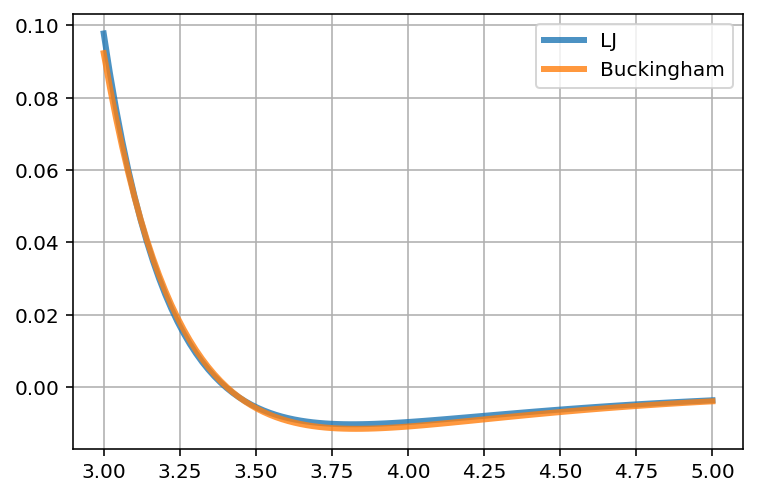

In [81]:
r = np.linspace(3, 5, 100)

plt.plot(r, E_lj(r, 3.4, 0.0103), lw=3,alpha=0.8)

plt.plot(r, E_buck(r, 10540.313, 3.66, 63.670), lw=3,alpha=0.8)

plt.legend(['LJ', 'Buckingham' ])

plt.grid(True)

### Non-bonded interactions: Electrostatics

In [7]:
def E_DH(r, kappa):
    
    """Debye-Huckel potential for acouting electrostaitc interactions in salt averaged (mean-field) manner.
    
    Parameters
    ----------
    r: Distance between two particles (Å)
    kappa: screening constant (inverse of screening length)
    """
    
    return np.exp(-kappa*r)/r

def E_coul(r):
    
    return 1/r

In [17]:
@widgets.interact(kappa=(0.1,5))
def plot_lj(kappa=0.1):
    
    r = np.linspace(1, 5, 1000)

    plt.plot(r, E_DH(r,kappa), lw=3)

    plt.ylim([0,1])
    plt.legend(['DH'])

    plt.grid(True)

interactive(children=(FloatSlider(value=0.1, description='kappa', max=5.0, min=0.1), Output()), _dom_classes=(…

## Integrating equations of motion

### No thanks, Euler
The simplest integrating scheme for ODEs is the Euler's method. Given the $n$-dimensional vectors from the ODE standard form

$$
\frac{d\mathbf{y}}{dt} = \mathbf{f}(t, \mathbf{y})
$$
the **Euler rule** amounts to

\begin{align}
\mathbf{f}(t, \mathbf{y}) = \frac{d\mathbf{y}(t)}{dt} &\approx \frac{\mathbf{y}(t_{n+1}) - \mathbf{y}(t_n)}{h}\\
\mathbf{y}_{n+1} &\approx \mathbf{y}_n + h \mathbf{f}(t_n, \mathbf{y}_n) \quad \text{with} \quad \mathbf{y}_n := \mathbf{y}(t_n)
\end{align}

**Much better integrators are known under the names of Runge Kutta, 2nd, 4th, 6th ... order**

In [228]:
def euler(y, f, t, h):
    
    """Euler integrator:
    Returns new y at t+h.
    """
    return y + h * f(t, y)

def rk2(y, f, t, h):
    
    """Runge-Kutta RK2 midpoint"""
    
    k1 = f(t, y)
    k2 = f(t + 0.5*h, y + 0.5*h*k1)
    
    return y + h*k2

def rk4(y, f, t, h):
    
    """Runge-Kutta RK4"""
    
    k1 = f(t, y)
    k2 = f(t + 0.5*h, y + 0.5*h*k1)
    k3 = f(t + 0.5*h, y + 0.5*h*k2)
    k4 = f(t + h, y + h*k3)
    
    return y + h/6 * (k1 + 2*k2 + 2*k3 + k4)

### Verlet algortihm

**Taylor expansion of position $\vec{r}(t)$ after timestep $\Delta t$**

$${r(t+\Delta t) = r(t) +v(t+\Delta t) +\frac{1}{2}a \Delta t^2+...}$$

$$r(t-\Delta t) = r(t) -v(t+\Delta t) +\frac{1}{2}a \Delta t^2+...$$

### Basic Verlet updating scheme

**In 1967 Loup Verlet introduced a central difference based algorithm into
molecular simulations**

$$r(t+\Delta t) = 2r(t) - r(t-\Delta t) +a(t) \Delta t^2+O(\Delta t^4)$$

$$ v(t) = \frac{r(t+\Delta t)-r(t-\Delta t)}{2\Delta t} +O(\Delta t^2) $$


- Not how terms of order $O(\Delta t^3)$ cancel in position giving position an accuracy of order $O(\Delta t^4)$

- Note how to update position we need positing in the past at two different time points

- How to get acceleration; $\vec{a} = \frac{\vec{F}}{m}$ We need to compute forces!

#### Need for a better Velocity update scheme

While velcotiy does not enter in the positing updating scheme of basic Verlet, we need the velcoity to set the temperature and to start the simulation from initital codnitions! This algorithms has shortcomings such as being of order $O(\Delta t^2)$ aaccuracy nd dependance on previous step. A better velocity updating scheme has been proposed known as Velocity-verlet which store positions, velocities and accelerations at the same time and which also minimize round-off errors:

$$\boxed{v(t+\Delta t) = v(t)+ \frac{a(t)+a(t+\Delta t)}{2}\Delta t +O(\Delta t^3)}$$

### Velocity Verlet scheme


- $$r(t+\Delta t) = r(t) + v(t)\Delta t + \frac{a(t)}{2}\Delta t^2 +O(\Delta t^3)$$

<br>

- $$v(t+\Delta t) = v(t)+ \frac{a(t)+a(t+\Delta t)}{2}\Delta t+ O(\Delta t^3)$$

### Velocity Verlet  Algorithm

The velocity verletequations can be decomposed into four steps:

1. Velcoity half-update-1: $$v(t+\Delta t/2) = v(t)+\frac{1}{2}a(t) \Delta t$$

2. Position update: $$r(t+\Delta t)  = r(t) +v(t+\Delta t/2)\Delta t$$

3. Force/acceleration evalutation: $$F = -\frac{\partial U(r)}{\partial r}\Big |_{r(t+\Delta t)} = m a(t+\Delta t)$$

4. Velcoity half-update-2: $$v(t+\Delta t) = v(t+\Delta t/2)+\frac{1}{2}a(t+\Delta t) \Delta t$$

In [326]:
def velv(y, f, t, h):
    
    """Velocity Verlet
    
    Low-performance implementation because the force is calculated
    twice; should remember the second force calculation and use as
    input for the next step.

    """
    
    # 1. Half step velocity
    F = f(t, y)
    y[1] += 0.5*h * F[1]

    # 2. Full step position
    y[0] += h*y[1]
    
    # 3. Force re-eval
    F = f(t+h, y)
    
    # 4. Full step velocity 
    #NOTE: force evaluation gets used in the the next iteration! Not very efficient
    y[1] += 0.5*h * F[1]  

    return y

### Comparison of RK and Verlet

In [370]:
def f(t, y):
    
    ''' Define a simple harmonic potential'''
    
    return np.array([y[1], -y[0]])

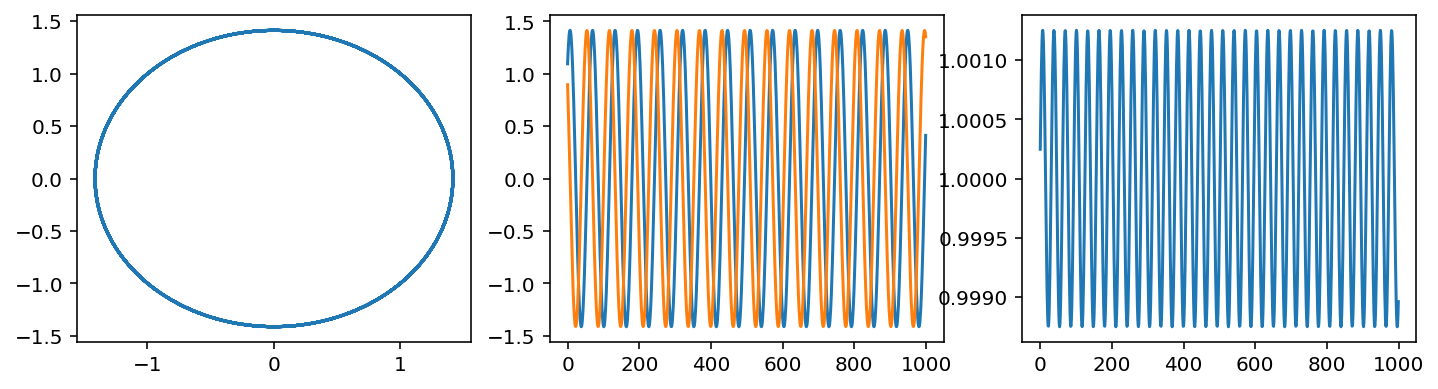

In [443]:
y  = np.array([1., 1.])
pos, vel = [], []
t  = 0

for i in range(1000):
    
    y = velv(y, f, t, h=0.1) # Change integration method and h=0.1
    t+=h
    
    pos.append(y[0])
    vel.append(y[1])

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3))

pos, vel =np.array(pos), np.array(vel)
ax[0].plot(pos, vel)
ax[1].plot(pos)
ax[1].plot(vel)
ax[2].plot(0.5*pos**2 + 0.5*vel**2)

## Average Properties

### Ensemble vs time average and ergodicity

$$\langle A \rangle  = \frac{1}{T_{prod}} \int^{T_{eq} +T_{prod}}_{T_{eq}} A(t)$$

### Kinetic, Potential and Total Energies

Energies are flcutuation quantities in the Molecualr dynamics:

- $$KE(t) = \sum_i \frac{p^2(t)}{2m}$$


- $$PE(t) = \sum_{ij}u_{ij}(r_i(t), r_j(t))$$


- $$E(t) = \sum_i \frac{p^2(t)}{2m} $$


$$\langle E \rangle = \langle KE \rangle +\langle PE \rangle \approx const $$

### Temperature

According to equipariting result of equilibrium statistical mechanics in the NVT ensmeble

$$\langle \sum_i \frac{p^2(t)}{2m} \rangle =\frac{3 }{2}N  k_B T$$


$$T_t = \frac{2}{3 N k_B} \langle KE \rangle_t $$

### Pressure

The microscopic expression for the pressure can be derived through mechanica considerations: 

$$P = \frac{1}{3V} \sum^N_i \Big [\frac{p^2_i}{m} +\vec{F}_i(r) \cdot \vec{r}_i(t) \Big ]$$

## Molecular Dynaamics of Classical Harmonic Oscillator

In [518]:
def ho_en_force(x,k=1,x0=0):
    
    energy = 0.5*k*(x-x0)**2
    force  = -k*(x-x0)
    
    return energy, force

In [519]:
@widgets.interact(k=(1,20))
def plot_harm_force(k):
    
    x = np.linspace(-3,3,1000)
    
    energy, force = ho_en_force(x, k) 
    
    plt.plot(x, energy, '-o',lw=3)
    plt.plot(x, force, '-', lw=3, alpha=0.5)
    
    plt.ylim([-25, 25])
    plt.grid(True)
    plt.legend(['$U(x)$', '$F=-\partial_x U(x)$'], fontsize=15)
    

interactive(children=(IntSlider(value=10, description='k', max=20, min=1), Output()), _dom_classes=('widget-in…

In [436]:
def ho_xv(t, A=1, omega=1, phi=0):
    
    x_t =  A*np.cos(omega*t+phi)
    
    v_t = -A*omega*np.sin(omega*t+phi)
    
    return x_t, v_t

def plot_ho_xv(A, omega, phi):
    
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,4))
    t = np.linspace(0,10,1000)
    
    x_t, v_t = ho_xv(t, A, omega, phi) 
    
    ax[0].plot(t, x_t)
    ax[0].plot(t, v_t)  
    ax[0].set_ylim([-3, 3])
    ax[0].grid(True)
    ax[0].set_xlabel('$t$')
    ax[0].legend(['x(t)','v(t)'])
    
    ax[1].plot(x_t, v_t, lw=1)
    ax[1].set_ylim([-3, 3])
    ax[1].grid(True)

In [437]:
@widgets.interact(A=(0.1,1), omega = (0.1,3), phi = (0, 2*np.pi))
def plot_ho_xv(A, omega, phi):
    
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,4))
    t = np.linspace(0,10,1000)
    
    x_t, v_t = ho_xv(t, A, omega, phi) 
    
    ax[0].plot(t, x_t)
    ax[0].plot(t, v_t)  
    ax[0].set_ylim([-3, 3])
    ax[0].grid(True)
    ax[0].set_xlabel('$t$')
    ax[0].legend(['x(t)','v(t)'])
    
    ax[1].plot(x_t, v_t, lw=1)
    ax[1].set_ylim([-3, 3])
    ax[1].grid(True)  

interactive(children=(FloatSlider(value=0.55, description='A', max=1.0, min=0.1), FloatSlider(value=1.55, desc…

### Molecualr Dynamics of Harmonic oscillator (NVE)

In [453]:
def vel_verlet_ho(x, v, k, dt, t_max=1000, freq=10):
    
    '''Minimalistic MD code 
    applied to a harmonic oscillator'''
    
    times, pos, vel, KE, PE  = [], [], [], [], []
    
    #Intialize force
    pe, F = ho_en_force(x, k)
    
    t = 0  
    
    for step in range(int(t_max/dt)):
        
        #1. Half update velocity
        v += 0.5*F*dt
        
        #2. Update the positions
        x += dt*v 
        
        #3. Re-compute the energy and force
        pe, F = ho_en_force(x, k)
        
        #4. Update velocity
        v += 0.5*F*dt
            
        t += dt
        
        if int(t)%freq == 0:
            
            times.append(t), pos.append(x), vel.append(v), KE.append(0.5*v*v), PE.append(pe)    
    
    return np.array(times), np.array(pos), np.array(vel), np.array(KE), np.array(PE)

In [454]:
E_tot = 2 # Exact value of total energy, let's see how MD preserves it
k = 3

x0 = np.sqrt(2*E_tot/k)
v0 = 0

#let's set a good timestep based on dt = tau/100 where tau=2 pi/ omega
omega = np.sqrt(k)
tau = 2*np.pi/omega
dt = tau/100.0

times, pos, vel, KE, PE = vel_verlet_ho(x0, v0, k, dt, t_max=10, freq=1)

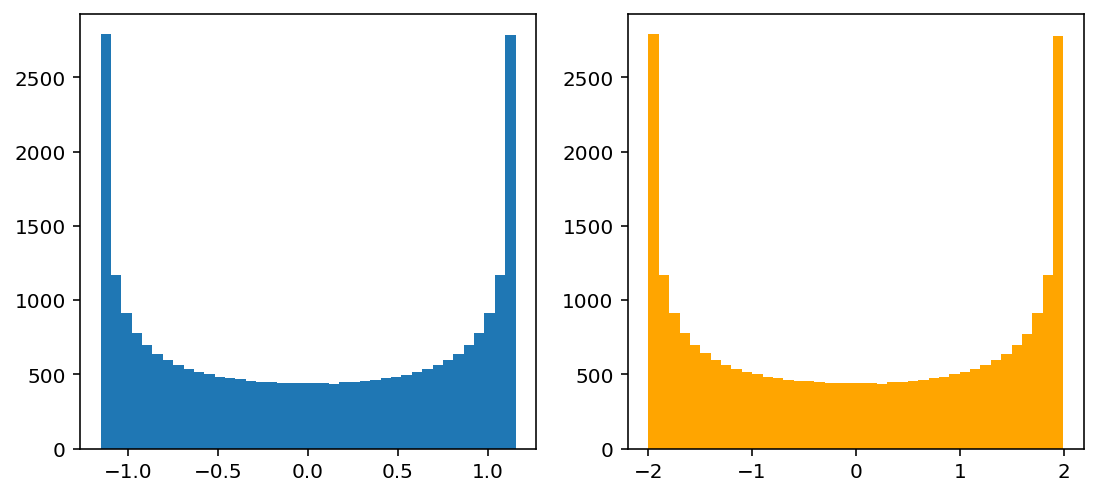

In [456]:
times, pos, vel, KE, PE = vel_verlet_ho(x0, v0, k, dt, t_max=1000, freq=1)

fig, ax =plt.subplots(ncols=2, nrows=1, figsize=(9,4))
ax[0].hist(pos, 40);
ax[1].hist(vel, 40,color='orange');

### Molecualr Dynamics of Harmonic oscillator (NVT)

### Langevin equation

**Newton: force  = gradient of energy landscape**

$$F =  m \ddot{x} = -\nabla_x U$$

**Langevin: force = friction (dissipation) + noise (fluctuation) on top of energy landscape**

- $$F = m \ddot{x} = -\nabla_x U - \lambda \dot{x} + \eta(t)$$

**Overdamped Langevin  $m\dot{v} =0$**

$$ \lambda \dot{x} = \nabla_x U + \eta(t)$$

**Fluctuation-dissipation theorem**

- $$\langle \eta(t) \eta(t') \rangle = 2\lambda k_B T \delta(t-t')$$

In [537]:
def langevin_md_1d(x, v, dt, kBT, gamma, t_max, freq, potential, **kwargs):
    
    '''Langevin dynamics applied to 1D potentials
    Using integration scheme known as BA-O-AB.
    INPUT: Any 1D function with its parameters
    '''
    
    times, pos, vel, KE, PE  = [], [], [], [], []
    
    t = 0  
    #x, v = x0, v0
    for step in range(int(t_max/dt)):
        
        #B-step
        pe, F = potential(x, **kwargs)
        v += F*dt/2
        
        #A-step
        x += v*dt/2

        #O-step
        v = v*np.exp(-gamma*dt) + np.sqrt(1-np.exp(-2*gamma*dt)) * np.sqrt(kBT) * normal()
        
        #A-step
        x +=  v*dt/2
        
        #B-step
        pe, F = potential(x, **kwargs)
        v +=  F*dt/2
        
        ### Save output
        if int(t)%freq == 0:
            
            times.append(t), pos.append(x), vel.append(v), KE.append(0.5*v*v), PE.append(pe)    
    
    return np.array(times), np.array(pos), np.array(vel), np.array(KE), np.array(PE)

In [538]:
# Ininital conditions
x     = 0.1
v     = 0.5

# Input parameters of simulation
kBT   = 0.25
gamma = 10
dt    = 0.01
t_max = 10000
freq  = 10

times, pos, vel, KE, PE = langevin_md_1d(x, v, dt, kBT, gamma, t_max, freq, ho_en_force, k=2)

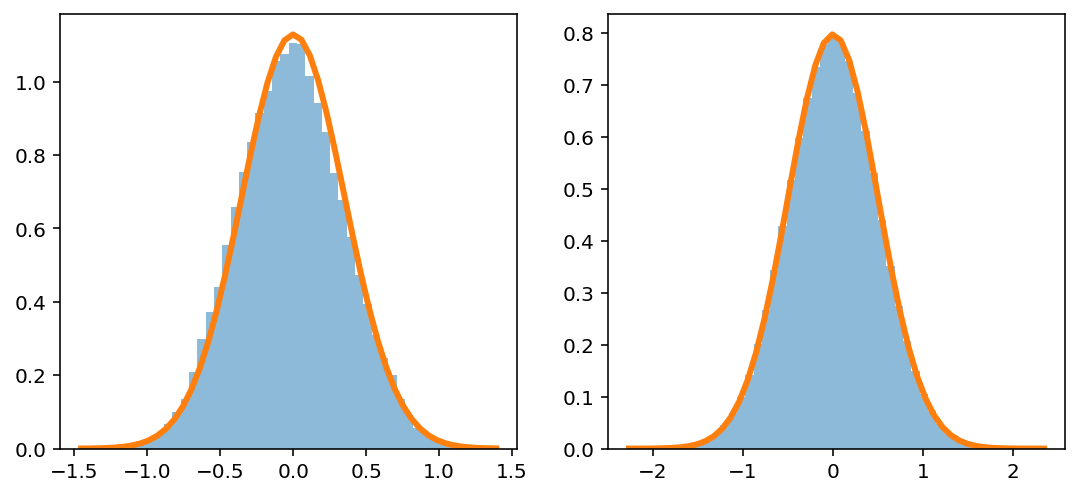

In [539]:
lambda gaussian_x = x: np.sqrt(2*np.pi*kBT/k) / np.exp(-k*(x**2)/(2*kBT))
    
lambda gaussian_v = v: np.sqrt(2*np.pi*kBT)   / np.exp(-(v**2)/(2*kBT))


fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(9,4))

x = np.linspace(min(pos), max(pos), 50)

ax[0].hist(pos, bins=50,normed=True, alpha=0.5) 
ax[0].plot(x, gaussian_x(x, k, kBT), lw=3)

v = np.linspace(min(vel), max(vel),50)

ax[1].hist(vel, bins=50, normed=True, alpha=0.5) 
ax[1].plot(v, gaussian_v(v, kBT), lw=3)

### Double well potential

(-10, 10)

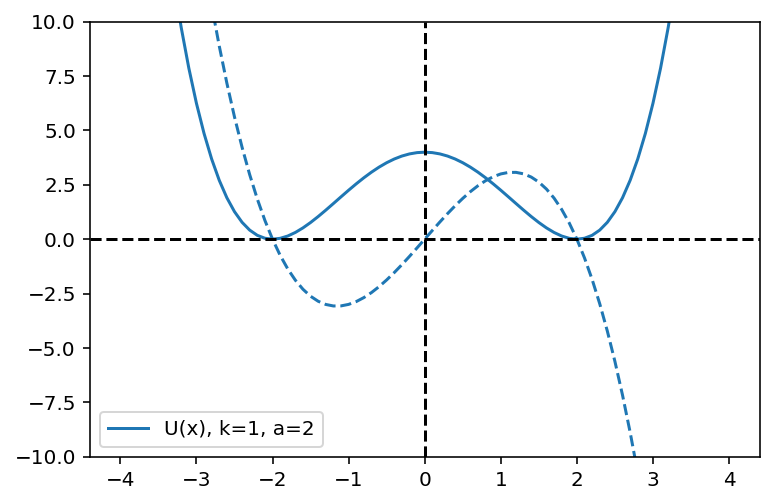

In [541]:
def double_well(x, k, a):
    
    energy = 0.25*k*((x-a)**2) * ((x+a)**2)
    force = -k*x*(x-a)*(x+a)
    
    return energy, force

plot_energy_force(double_well_energy_force, xmin=-4,xmax=+4, k=1, a=2)
plt.axhline(0,linestyle='--',color='black')
plt.axvline(0,linestyle='--',color='black')

plt.ylim(-10,10)

In [551]:
# Ininital conditions
x     = 0.1
v     = 0.5

# Input parameters of simulation
kBT   = 5 # vary this
gamma = 0.1 # vary this

dt    = 0.05
t_max = 10000
freq  = 10

times, pos, vel, KE, PE = langevin_md_1d(x, v, dt, kBT, gamma, t_max, freq, double_well, k=1, a=3)

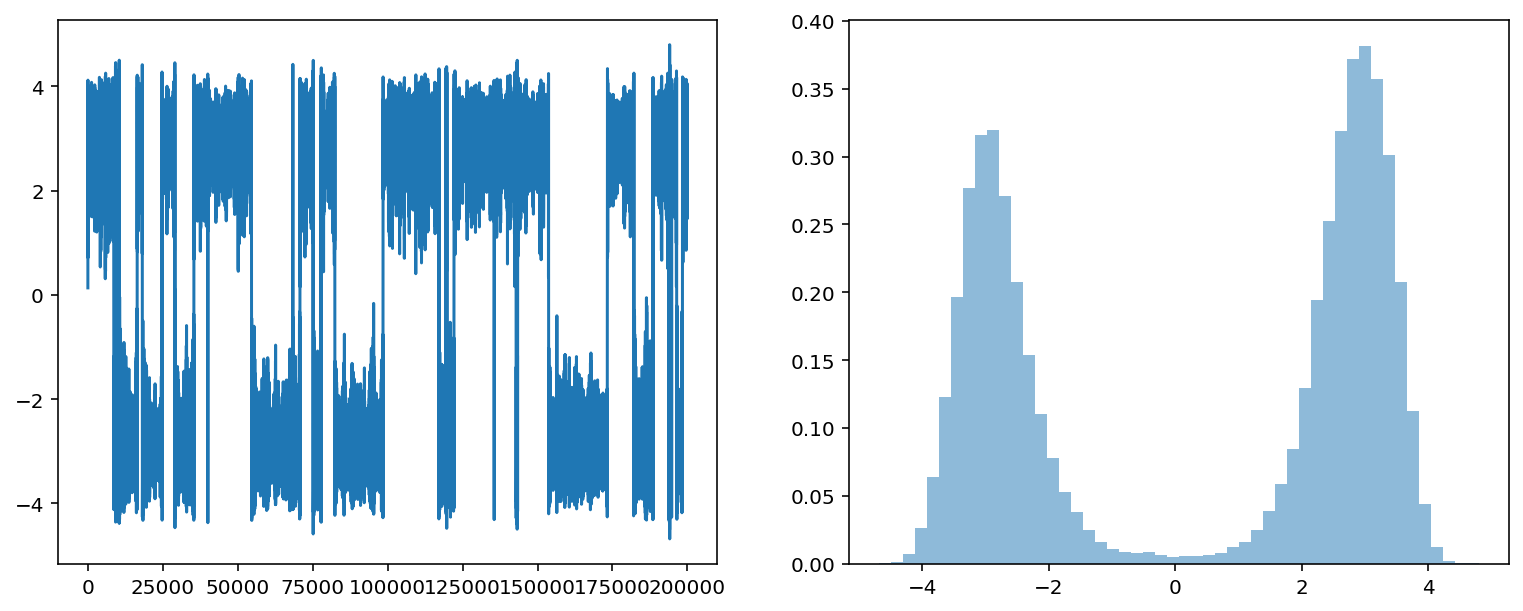

In [559]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(13,5))

x = np.linspace(min(pos), max(pos), 50)


ax[0].plot(pos)

ax[1].hist(pos, bins=50,normed=True, alpha=0.5);
#ax[0].plot(x, gaussian_x(x, k, kBT), lw=3)

v = np.linspace(min(vel), max(vel),50)

### Final HW

#### Problem-1 
Given a 1D potential $U(x)$ write code to carry out  molecular dynamics

$$U(x) = Ax^2 +B x^3 + C x^4$$

- Input should read in A, B, C parameters, starting point and velocity , timestep and number of iterations.

- Output should be the positions which should then be histogrammed to obtain probability distribution

- Use A=-1, B = 0.0, C = 1.0. Try various initial positions.  Look fer interesting regions to sample by adjusting initital position.  

- Use A=-1, B = -1, C = 1.0. Again try various initial positions.

#### Problem-2

Simulate chain of harmonic oscillators with potential energy

$$U(x) = \sum_j \frac{p^2_j}{2m} + \frac{1}{2} K \sum_j (x_j -x_{j-1})^2$$

- Take the particle at $x_0 = 0$ fixed. Carry out constant T MD. 

- Try N = 2, N=10 particles and obtain equilibrium distributions of $x_{j}-x_{j-1}$ for various temperatures